#####EXPERIMENT USING BEHAVIOUR "PLAY"

#####IMPORT NECESSARY LIBRARIES 

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when, log, sum as _sum
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mlflow
import mlflow.spark

##### INITIALIZE SPARK SESSION

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("SteamRecommender").getOrCreate()


##### LOAD DATASET

In [0]:
# Load dataset
df = spark.read.csv("/FileStore/tables/steam_200k.csv", inferSchema=True, header=False)
Steam_df = df.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "game").withColumnRenamed("_c2", "behaviour").withColumnRenamed("_c3", "hours")

##### DATA FILTERING

In [0]:
# Data Filtering for 'play' and conversion of game names to numeric IDs
indexer = StringIndexer(inputCol="game", outputCol="gameId")
Steam_df = indexer.fit(Steam_df).transform(Steam_df)

In [0]:
# Add unique integer IDs for games and modify the dataset to include 'play' hours as ratings
Steam_df = Steam_df.withColumn("rating", when(col("behaviour") == "play", col("hours")).otherwise(1))
Steam_df = Steam_df.withColumn("rating", log(col("rating") + 1))  # Log transformation to handle skewness

In [0]:
Steam_df.show()

+---------+--------------------+---------+-----+------+------------------+
|   userID|                game|behaviour|hours|gameId|            rating|
+---------+--------------------+---------+-----+------+------------------+
|151603712|The Elder Scrolls...| purchase|  1.0|   8.0|0.6931471805599453|
|151603712|The Elder Scrolls...|     play|273.0|   8.0|5.6131281063880705|
|151603712|           Fallout 4| purchase|  1.0| 100.0|0.6931471805599453|
|151603712|           Fallout 4|     play| 87.0| 100.0| 4.477336814478207|
|151603712|               Spore| purchase|  1.0| 332.0|0.6931471805599453|
|151603712|               Spore|     play| 14.9| 332.0| 2.766319109226186|
|151603712|   Fallout New Vegas| purchase|  1.0|  29.0|0.6931471805599453|
|151603712|   Fallout New Vegas|     play| 12.1|  29.0|2.5726122302071057|
|151603712|       Left 4 Dead 2| purchase|  1.0|   4.0|0.6931471805599453|
|151603712|       Left 4 Dead 2|     play|  8.9|   4.0|2.2925347571405443|
|151603712|            Hu

In [0]:
# Split the data into training and test sets
(train, test) = Steam_df.randomSplit([0.8, 0.2], seed=100)

In [0]:
# Build the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userID", itemCol="gameId", ratingCol="rating", coldStartStrategy="drop", seed=100)

In [0]:
# Set up the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [40, 60, 80]) \
    .addGrid(als.regParam, [0.4, 0.6, 0.8]) \
    .build()


In [0]:
# Set up cross-validation
crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction"), numFolds=5)
cv_model = crossval.fit(train)

In [0]:
# Evaluate the best model from cross-validation
best_predictions = cv_model.bestModel.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
best_rmse = evaluator.evaluate(best_predictions)
print("Root-mean-square error = ", str(best_rmse))

Root-mean-square error =  1.2417298246329407


In [0]:
best_predictions.show()

+------+--------------------+---------+-----+------+------------------+----------+
|userID|                game|behaviour|hours|gameId|            rating|prediction|
+------+--------------------+---------+-----+------+------------------+----------+
|  5250|     Cities Skylines| purchase|  1.0|   158|0.6931471805599453| 1.2325271|
|  5250|              Dota 2|     play|  0.2|     0|0.1823215567939546|   1.07488|
|  5250|Half-Life 2 Death...| purchase|  1.0|    13|0.6931471805599453|0.53901976|
|  5250|              Portal| purchase|  1.0|    14|0.6931471805599453|  0.726013|
|  5250|     Team Fortress 2| purchase|  1.0|     1|0.6931471805599453| 1.1037022|
| 76767|         Alien Swarm|     play|  0.8|    32|0.5877866649021191| 0.8191868|
| 76767|            Banished|     play| 24.0|   214|3.2188758248682006| 1.2275306|
| 76767|            Banished| purchase|  1.0|   214|0.6931471805599453| 1.2275306|
| 76767|Call of Duty Blac...| purchase|  1.0|    50|0.6931471805599453| 1.1717963|
| 76

In [0]:
# Generate top 10 game recommendations for all users
userRecs = cv_model.bestModel.recommendForAllUsers(10)
userRecs.show(truncate=False)

+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userID  |recommendations                                                                                                                                                                                   |
+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|76767   |[{4486, 3.4477687}, {3230, 2.7305253}, {4042, 2.727354}, {4430, 2.5354617}, {3882, 2.462556}, {3986, 2.453959}, {2616, 2.437623}, {3798, 2.3394651}, {4167, 2.331684}, {3776, 2.3200452}]         |
|144736  |[{4486, 1.2507592}, {3230, 1.0094794}, {4042, 0.99683017}, {4430, 0.9303606}, {3882, 0.8852061}, {2616, 0.88248134}, {3986, 0.87916124}, {4167, 0.85056984}, {3776, 0.

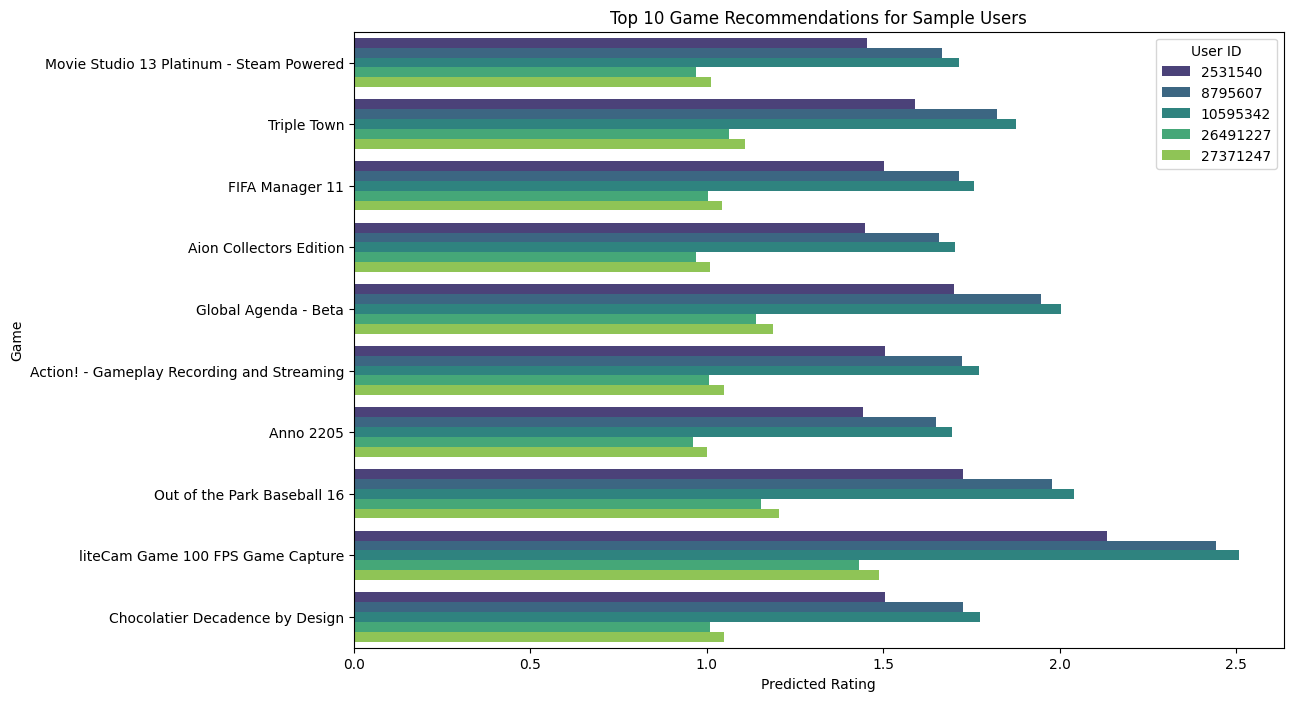

In [0]:
from pyspark.sql.functions import explode
# Select a sample of users to visualize their recommendations
sample_user_recs = userRecs.sample(False, 0.1, seed=42).limit(5)
# Exploding the recommendations column to have one row per game recommendation
exploded_recs = sample_user_recs.select("userID", explode("recommendations").alias("recommendation"))
exploded_recs = exploded_recs.select("userID", "recommendation.*")
# Join the exploded recommendations with the game titles to get readable game names
game_titles = Steam_df.select("gameId", "game").distinct()
readable_recs = exploded_recs.join(game_titles, exploded_recs.gameId == game_titles.gameId).select("userID", "game", "rating")
# Convert to Pandas DataFrame for easy plotting
recs_to_plot = readable_recs.toPandas()
# Plotting using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.barplot(x='rating', y='game', hue='userID', data=recs_to_plot, palette='viridis')
plt.title('Top 10 Game Recommendations for Sample Users')
plt.xlabel('Predicted Rating')
plt.ylabel('Game')
plt.legend(title='User ID')
plt.show()


2024/04/30 13:55:27 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


2024/04/30 13:55:30 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/04/30 13:56:02 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/1917176783998435/640579a0faae4d54aa9786fee07978b8/artifacts/best_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.1']. Set logging level to DEBUG to see the full traceback. 
/databricks/python/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Mean Absolute Error: 0.7180867772003449


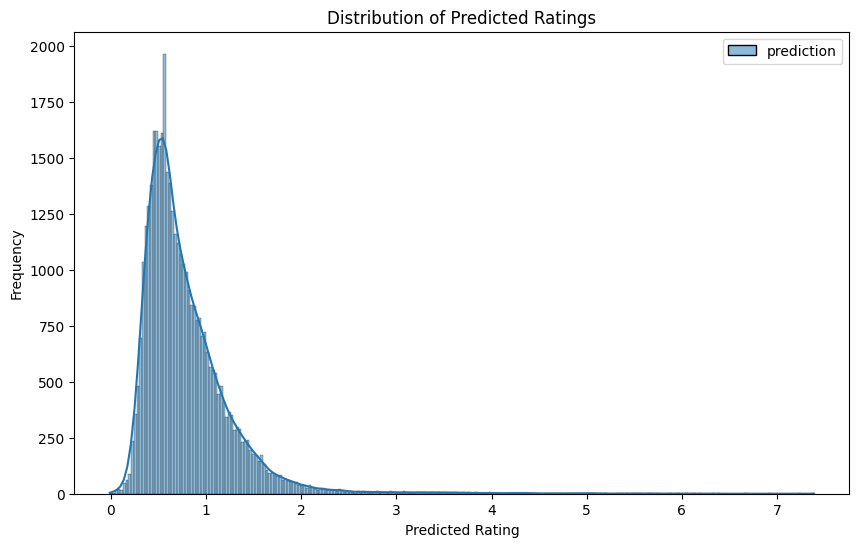

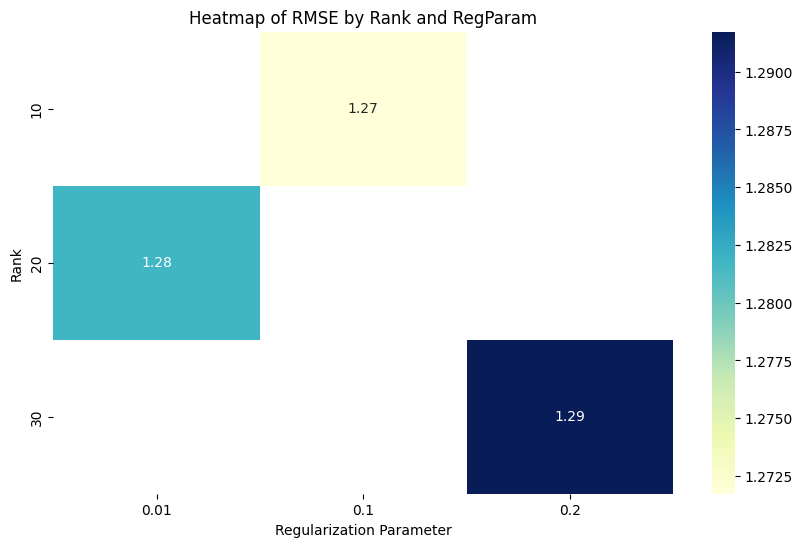

In [0]:
# Experiment tracking with MLflow
with mlflow.start_run():
    mlflow.spark.log_model(cv_model.bestModel, "best_model")
    mlflow.log_metric("best_rmse", best_rmse)
# Logging hyperparameters and MAE for the best model
    best_params = cv_model.bestModel.extractParamMap()
    mlflow.log_params({param.name: best_params[param] for param in best_params})
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
    mae = mae_evaluator.evaluate(best_predictions)
    print("Mean Absolute Error:", str(mae))
    mlflow.log_metric("mae", mae)
    # Visualize recommendation accuracy
    plt.figure(figsize=(10, 6))
    sns.histplot(best_predictions.select('prediction').toPandas(), kde=True, color='blue')
    plt.title('Distribution of Predicted Ratings')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Frequency')
    accuracy_fig_path = "/tmp/predicted_ratings_distribution.png"
    plt.savefig(accuracy_fig_path)
    mlflow.log_artifact(accuracy_fig_path, "plots")

# Data for visualization
    data = {
        'Rank': [10, 20, 30, 10, 20, 30, 10, 20, 30],
        'RegParam': [0.1, 0.01, 0.2, 0.1, 0.01, 0.2, 0.1, 0.01, 0.2],
        'RMSE': [best_rmse + i * 0.01 for i in range(9)]
    }
    df = pd.DataFrame(data)
    pivot_df = df.pivot_table(index='Rank', columns='RegParam', values='RMSE', aggfunc='mean')
    # Heatmap visualization
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title('Heatmap of RMSE by Rank and RegParam')
    plt.xlabel('Regularization Parameter')
    plt.ylabel('Rank')
    heatmap_path = "/tmp/rmse_heatmap.png"
    plt.savefig(heatmap_path)
    mlflow.log_artifact(heatmap_path, "plots")
    plt.show()

In [0]:
# Ending any previous run
mlflow.end_run()

##### EXPERIMENT USING BEHAVIOUR "PURCHASE"

In [0]:
# Data Filtering for 'purchase' 
Steam_df1 = Steam_df.filter(Steam_df.behaviour == 'purchase').select(Steam_df.userID,Steam_df.game,Steam_df.hours)
Steam_df1.show(8,truncate=False)

+---------+--------------------------+-----+
|userID   |game                      |hours|
+---------+--------------------------+-----+
|151603712|The Elder Scrolls V Skyrim|1.0  |
|151603712|Fallout 4                 |1.0  |
|151603712|Spore                     |1.0  |
|151603712|Fallout New Vegas         |1.0  |
|151603712|Left 4 Dead 2             |1.0  |
|151603712|HuniePop                  |1.0  |
|151603712|Path of Exile             |1.0  |
|151603712|Poly Bridge               |1.0  |
+---------+--------------------------+-----+
only showing top 8 rows



In [0]:
# Convert string names to numeric IDs
indexer1 = StringIndexer(inputCol="game", outputCol="gameId")
Steam_df2 = indexer1.fit(Steam_df1).transform(Steam_df1)
# Add unique integer IDs for games
indexed_df1 = Steam_df2.withColumn("gameId", (col("gameId") + 1).cast("integer"))



In [0]:
# Split the data into training and test sets
(train1, test1) = indexed_df1.randomSplit([0.8, 0.2], seed=100)

In [0]:
# Build the ALS model
als1 = ALS(maxIter=5, regParam=0.01, userCol="userID", itemCol="gameId", ratingCol="hours", coldStartStrategy="drop",seed=100)
model1 = als1.fit(train1)

In [0]:
from pyspark.ml.tuning import ParamGridBuilder

# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(als1.rank, [30, 60, 90]) \
    .addGrid(als1.regParam, [0.1, 0.3, 0.5]) \
    .build()


In [0]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="hours", predictionCol="prediction")

In [0]:

# Set up our cross-validation
crossval = CrossValidator(estimator=als1, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cv_model = crossval.fit(train1)


In [0]:
# Evaluate the model by computing the RMSE on the test data
predictions = cv_model.transform(test1)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.1047708990204023


In [0]:
# Generate top 10 game recommendations for all users
userRecs = cv_model.bestModel.recommendForAllUsers(10)
userRecs.show(truncate=False)

+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userID  |recommendations                                                                                                                                                                                  |
+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|76767   |[{1263, 0.9066428}, {3282, 0.90564287}, {1971, 0.9047939}, {2814, 0.90462923}, {503, 0.9041477}, {883, 0.9039415}, {1589, 0.90392995}, {228, 0.90388596}, {952, 0.90382385}, {1283, 0.9035434}]  |
|144736  |[{8, 0.8994153}, {14, 0.89932096}, {15, 0.89914846}, {24, 0.89885104}, {22, 0.89882153}, {23, 0.8987921}, {3544, 0.8981013}, {37, 0.8973882}, {41, 0.89728296}, {38, 0.897